In [ ]:
! nvidia-smi

Sun May  2 04:40:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparation for Colab
## Pytorch version
Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "11.2":
    torch_version_suffix = "+cu112"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.0


In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.2MB/s eta 0:04:21tcmalloc: large alloc 1147494400 bytes == 0x564c165a0000 @  0x7f77c3da1615 0x564bdd6be06c 0x564bdd79deba 0x564bdd6c0e8d 0x564bdd7b299d 0x564bdd734fe9 0x564bdd72fb0e 0x564bdd6c277a 0x564bdd734e50 0x564bdd72fb0e 0x564bdd6c277a 0x564bdd73186a 0x564bdd7b37c6 0x564bdd730ee2 0x564bdd7b37c6 0x564bdd730ee2 0x564bdd7b37c6 0x564bdd730ee2 0x564bdd7b37c6 0x564bdd835431 0x564bdd796049 0x564bdd700c84 0x564bdd6c18e9 0x564bdd735ade 0x564bdd6c269a 0x564bdd730a45 0x564bdd72fe0d 0x564bdd6c277a 0x564bdd730a45 0x564bdd6c269a 0x564bdd730a45
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:26tcmalloc: large alloc 1434370048 bytes == 0x564c5abf6000 @  0x7f77c3da1615 0x564bdd6be06c 0x564bdd79deba 0x564bdd6c0e8d 0x564bdd7b299d 0x564bdd734fe9 0x564bdd72fb0e 0x564bdd6c277a 0x564bdd734e50 0x564bdd72fb0e 0x564bdd6c277a 0x564bdd73186a 0x564bdd7b37c6 0x564bdd730ee2 0

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import math
import copy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu110


# Preliminaries

In this section we define some utility functions that are going to be necessary later on

In [ ]:
import torch
from typing import List

In [ ]:
def padded_stack(tensors: List[torch.Tensor], pad_value=0) -> torch.Tensor: 
  """This functions stack together a list of 1D tensors, padding the shorter ones so they have the same length"""

  if len(tensors) == 0:
    # No tensors, nothing to do
    return torch.zeros(0,0)

  # Get the lenght of the longest tensor
  max_len = max([t.shape[0] for t in tensors]) 

  # Prepapre the output tensor of the correct size
  padded_tensor = torch.full((len(tensors), max_len), pad_value) 

  # Loop over the tensors, and write them in the correct position
  for i, t in enumerate(tensors):
    assert t.ndim == 1, "Error, the padding sequence is expecting 1d sequences"
    padded_tensor[i, :len(t)] = t
  return padded_tensor

In [ ]:
def padded_collate(batch):
  """ This function receives a list of (input, target) elements, and batches them into (batched_inputs, batched_outputs)"""
  batch = list(zip(*batch))

  # We pad with -100, because it's the "ignore_index" of pytorch's cross-entropy
  batch[0] = padded_stack(batch[0], -100)
  batch[1] = padded_stack(batch[1], -100)
  return tuple(batch)

In [ ]:
def padded_collate_with_lengths(batch):
  """ This function receives a list of (input, target) elements, and batches them into (batched_inputs, input_lengths, batched_outputs, output_lengths)"""
  batch = list(zip(*batch))
  out_batch = []
  out_batch.append(padded_stack(batch[0], -100))
  out_batch.append(torch.as_tensor([len(s) for s in batch[0]], dtype=torch.long))
  out_batch.append(padded_stack(batch[1], -100))
  out_batch.append(torch.as_tensor([len(s) for s in batch[1]], dtype=torch.long))
  return tuple(out_batch)

# Synthetic tasks

## Problem definition

To probe the capabilities of various architectures, we start by exploring some synthetic tasks. These tasks are designed to be very easy to understand and solve for a human, but we’ll see that they can nonetheless push NLP models to their limits.

We start with a simple copy task: given a sequence of arbitrary length, the model should output the exact same sequence.

We define a dataset class that generates such data

In [ ]:
import torch
from random import randint

# Index of the special token "End-Of-Sequence"
EOS = 0
# Index of the special token "Start-Of-Sequence"
SOS = 1
# Our class inherits from pytorch's dataset class
class CopyDataset(torch.utils.data.Dataset):
  def __init__(self, min_length=1, max_length=20, vocab_size=20):
    super().__init__()
    assert vocab_size > 2, "Error, vocabulary too small. Note that we reserve two tokens for EOS and SOS"
    self.min_length = min_length
    self.max_length = max_length
    self.vocab_size = vocab_size

  def __len__(self):
    return 1000000 # Arbitrary dataset length

  def __getitem__(self, idx):
    # Here we generate a random sample.

    # Sample the length of the sequence
    length = randint(self.min_length, self.max_length)

    # Sample the content. We generate ints >= 2, because 0 and 1 are reserved for EOS and SOS
    input = torch.randint(2, self.vocab_size, (length + 1,))
    
    input[-1] = EOS # The last token is a special class called "End of Sequence" or EOS
    return input, input # the target is the input


In [ ]:
dataset = CopyDataset()

In [ ]:
dataset[4]

(tensor([14, 17, 13, 18,  7,  7, 10,  6,  9, 13, 10, 16, 15,  0]),
 tensor([14, 17, 13, 18,  7,  7, 10,  6,  9, 13, 10, 16, 15,  0]))

## Simple RNN, slow version


We are going to use a simple GRU cell, as depicted below. For this first implementation, we will implement everything ourselves, leading to a slower code.

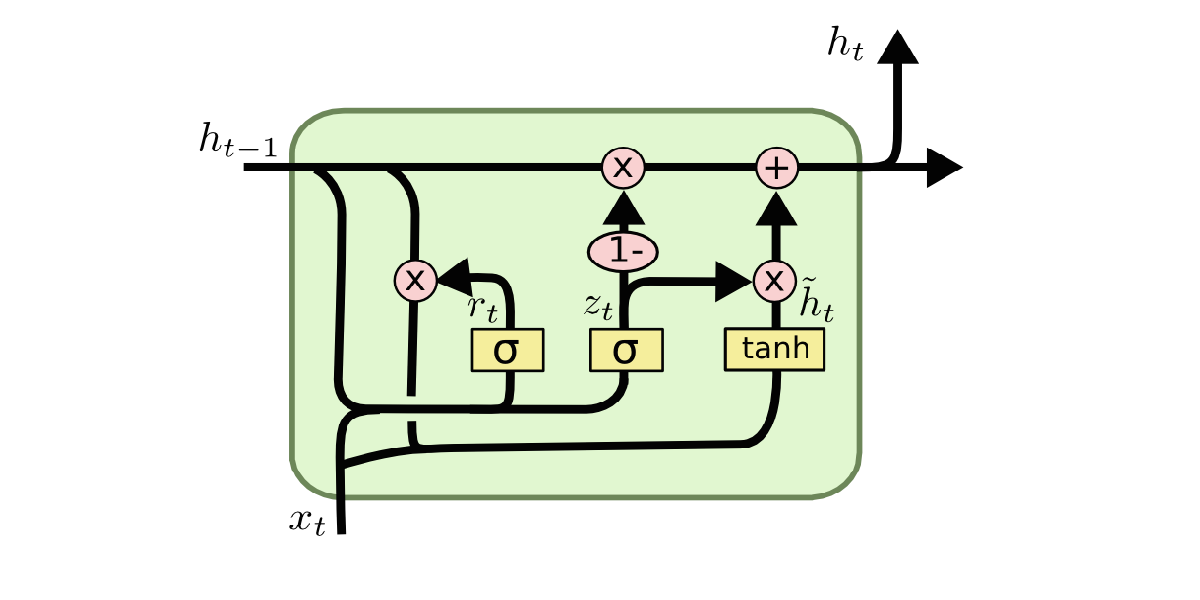

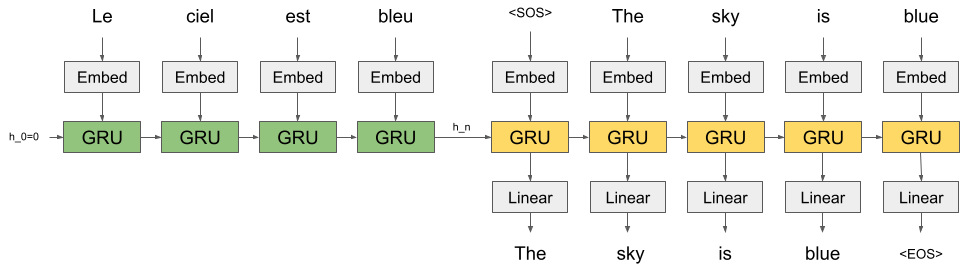

For training, we use a technic known as "teacher forcing" (see image above). At each time-step, during decoding, the model receives the ground-truth word at that position, irrespective of what it has actually predicted at the previous time-step.

In [ ]:
class RNNEncoderDecoderSlow(torch.nn.Module):
  def __init__(self, d_model=32, vocab_size=30):
    super(RNNEncoderDecoderSlow, self).__init__()

    # The embedding converts the tokens indices into a vector of dimension d_model
    self.embeddings = torch.nn.Embedding(vocab_size, d_model)
    # We have two GRUCell, one for encoding and one for decoding.
    self.encoder = torch.nn.GRUCell(input_size=d_model, hidden_size=d_model)
    self.decoder = torch.nn.GRUCell(input_size=d_model, hidden_size=d_model)
    
    # The head projects back to the vocabulary space
    self.head = torch.nn.Linear(d_model, vocab_size)
    self.d_model = d_model

  def encode(self, input, lengths):
    """
    input : long tensor of dim [batch_size, seq_len] 
    lengths: long tensor of dim [batch_size] containing the length of each sequence of the batch
    """
    batch_size = input.shape[0]
    assert lengths.shape[0] == batch_size

    # Here we replace the -100 used in padding, because the embedding wouldn't accept them.
    ignore = input == -100
    input = input.masked_fill(ignore, 0)

    # embed the tokens
    embedded = self.embeddings(input)  # [batch_size, seq_len, nb_feats]

    # This is our hidden state. We initialize it to 0s
    hidden = torch.zeros((batch_size, self.d_model), device=input.device)

    max_len = torch.max(lengths).item()
    assert max_len <= input.shape[1]

    # We iterate over time-steps
    for i in range(max_len):
      current_active = i < lengths  # binary mask, telling us which sequences are being forwarded

      hidden[current_active] = self.encoder(embedded[current_active, i], hidden[current_active])

    return hidden

  def decode(self, hidden, target, target_lengths):
    bs = target.shape[0]
    # Prepend start of sequence (SOS)
    target = torch.cat((torch.full((bs, 1,), SOS, device=target.device, dtype=target.dtype), target), dim=1)

    ignore = target == -100
    target = target.masked_fill(ignore, 0)
    embedded = self.embeddings(target)

    target_lengths = target_lengths + 1 # adding 1 because of SOS

    max_len = torch.max(target_lengths).item() 
    assert max_len <= target.shape[1]

    # This list will contain the hidden states at each time-steps
    decoded = []
    for i in range(max_len):
      current_active = i < target_lengths # binary mask, telling us which sequences are being forwarded

      hidden[current_active] = self.decoder(embedded[current_active, i], hidden[current_active])
      decoded.append(hidden.clone())

    # We stack the hidden states on the sequence dimension
    decoded = torch.stack(decoded, dim=1) # bs x max_len x d_model
    # Use the head to project back to the token space.
    return self.head(decoded)[:, :-1]

  def forward(self, input, input_lengths, target, target_lengths):
    return self.decode(self.encode(input, input_lengths), target, target_lengths)

  def inference(self, input, lengths, max_len=100):   
    """
    input : long tensor of dim [batch_size, seq_len] 
    lengths: long tensor of dim [batch_size] containing the length of each sequence of the batch
    max_len: int corresponding to the maximal length of the sequence we should decode.
             this is useful if the decoder gets stuck and never outputs EOS
    """
    batch_size = input.shape[0]
    device = input.device
    # track which sequences are fully decoded
    done = torch.zeros(batch_size, dtype=torch.bool, device=device)

    # First, encode the sequence
    hidden = self.encode(input, lengths)
    
    decoded_seq = [[] for _ in range(batch_size)]
    decoded_vec = self.embeddings(torch.full((batch_size,), SOS,  device=device, dtype=input.dtype)) # Start of sequence
    # greedy decoding
    for i in range(max_len):
      if done.all().item():
        break

      hidden = self.decoder(decoded_vec, hidden)

      # Decode the prediction
      prediction = self.head(hidden).view(batch_size, -1).argmax(-1)

      # Re-encode for the next step
      decoded_vec = self.embeddings(prediction)

      # Check which sequences have finished at this step
      done = done | (prediction == EOS)

      for j in range(batch_size):
        if done[j]:
          continue
        decoded_seq[j].append(prediction[j].item())

    return decoded_seq

In [ ]:
dataset = CopyDataset(max_length=5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate_with_lengths)

In [ ]:
def validate(model, dataset, num=1000):
  """This is a validation function to track some statistics of our model"""

  # Get examples from the dataset
  examples = [dataset[i] for i in range(num)]

  # Manually collate using our collate function
  src, src_len, tgt, tgt_len = padded_collate_with_lengths(examples)

  # Move everything to the gpu
  src = src.cuda()
  tgt = tgt.cuda()
  src_len = src_len.cuda()
  tgt_len = tgt_len.cuda()

  # Compute predictions
  prediction = model(src, src_len, tgt, tgt_len).argmax(-1)

  # Compute the character-level accuracy, on the non-padding tokens
  valid = tgt != -100
  acc = prediction[valid] == tgt[valid]
  acc = (acc.sum()) / (valid.sum())
  char_acc = acc.item()*100

  # Do a real inference and compute the sequence-level accuracy
  inferred = model.inference(src, src_len)
  valid = 0
  for i in range(num):
    if inferred[i] == examples[i][1].tolist()[:-1]:
      valid += 1

  return char_acc, 100*valid/num


In [ ]:
model = RNNEncoderDecoderSlow(d_model=128).cuda()
# Use SGD as the optimiser, with momentum
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for i,(src, src_len, tgt, tgt_len) in enumerate(dataloader):
  src = src.cuda()
  tgt = tgt.cuda()
  src_len = src_len.cuda()
  tgt_len = tgt_len.cuda()
  optim.zero_grad()
  prediction = model(src, src_len, tgt, tgt_len)

  # cross entropy loss. Remember that the ignore index is taking care of the padding.
  loss = torch.nn.functional.cross_entropy(prediction.flatten(0,1), tgt.flatten())


  loss.backward()
  optim.step()
  if i % 100 == 0:
    char_acc, seq_acc = validate(model, dataset, 2000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Char level accuracy=5.36	 Seq level accuracy=0.0	 loss=3.390458583831787
Char level accuracy=54.19	 Seq level accuracy=27.3	 loss=1.245863676071167
Char level accuracy=91.33	 Seq level accuracy=78.2	 loss=0.4149447977542877
Char level accuracy=96.16	 Seq level accuracy=88.0	 loss=0.16968756914138794
Char level accuracy=97.61	 Seq level accuracy=91.25	 loss=0.11260531097650528
Char level accuracy=98.36	 Seq level accuracy=93.95	 loss=0.07561689615249634
Char level accuracy=98.73	 Seq level accuracy=95.5	 loss=0.05877017229795456
Char level accuracy=99.21	 Seq level accuracy=97.05	 loss=0.04925786331295967
Char level accuracy=99.32	 Seq level accuracy=97.55	 loss=0.04417609050869942
Char level accuracy=99.42	 Seq level accuracy=97.8	 loss=0.032309502363204956
Char level accuracy=99.67	 Seq level accuracy=98.7	 loss=0.023816293105483055
Char level accuracy=99.47	 Seq level accuracy=98.0	 loss=0.02847229316830635
Char level accuracy=99.74	 Seq level accuracy=98.95	 loss=0.01838185265660286

We can see that the model reaches almost perfect accuracy on this task. It should be possible to reach exactly 100% with additional tricks, but this is beyond the scope of this tutorial. Let's do inference on a single sequence to convince ourselves that the model does indeed work:

In [ ]:
model.inference(torch.as_tensor([[6,7,8,9,10,  EOS]]).cuda(), torch.as_tensor([6], dtype=torch.long).cuda())

[[6, 7, 8, 9, 10]]

## Simple RNN

The previous model relied on manual for-loops to forward through the model. This is tedious, bug-prone, and most importantly, slow. To utilize GPU/TPUs efficiently, one must avoid loops as much as possible, and rely on parallelization instead.

By nature, RNNs are a bit hard to vectorize, but Pytorch provides a very handy tool, namely Packed Sequences.

In [ ]:
class RNNEncoderDecoder(torch.nn.Module):
  def __init__(self, d_model=32, vocab_size=30):
    super(RNNEncoderDecoder, self).__init__()
    self.embeddings = torch.nn.Embedding(vocab_size, d_model)

    # GRU is a wrapper over a GRUCell. It also supports multi layers RNN
    self.encoder = torch.nn.GRU(input_size=d_model, hidden_size=d_model, batch_first=True)
    self.decoder = torch.nn.GRU(input_size=d_model, hidden_size=d_model, batch_first=True)
    
    self.head = torch.nn.Linear(d_model, vocab_size)
    self.d_model = 32

  def encode(self, input, lengths):
    """
    input : long tensor of dim [batch_size, seq_len] 
    lengths: long tensor of dim [batch_size] containing the length of each sequence of the batch
    """
    batch_size = input.shape[0]
    assert lengths.shape[0] == batch_size

    ignore = input == -100
    input = input.masked_fill(ignore, 0)
    embedded = self.embeddings(input)

    # This is the pytorch magic. No more for loop, only one call to the encoder forward.
    packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
    return self.encoder(packed)[1] 

  def decode(self, hidden, target, target_lengths):
    bs = target.shape[0]
    # Append start of sequence (SOS)
    target = torch.cat((torch.full((bs, 1,), SOS, device=target.device, dtype=target.dtype), target), dim=1)

    ignore = target == -100
    target = target.masked_fill(ignore, 0)
    embedded = self.embeddings(target)
    packed = pack_padded_sequence(embedded, target_lengths + 1, batch_first=True, enforce_sorted=False)
    decoded, _ = self.decoder(packed, hidden)

    # we "unpack"
    decoded, _ = pad_packed_sequence(decoded, batch_first=True)
    
    return self.head(decoded)[:, :-1]

  def forward(self, input, input_lengths, target, target_lengths):
    return self.decode(self.encode(input, input_lengths), target, target_lengths)

  def inference(self, input, input_lengths, max_len=100):
    # track which sequences are done
    batch_size = input.shape[0]
    device = input.device
    done = torch.zeros(batch_size, dtype=torch.bool, device=device)

    # Append start of sequence (SOS)
    hidden = self.encode(input, input_lengths)
    
    decoded_seq = [[] for _ in range(batch_size)]
    decoded_vec = self.embeddings(torch.full((batch_size, 1,), SOS,  device=device, dtype=input.dtype)) # Start of sequence
    # greedy decoding
    for i in range(max_len):
      if done.all().item():
        break

      decoded, hidden = self.decoder(decoded_vec, hidden)

      # Decode the prediction
      prediction = self.head(decoded).view(batch_size, -1).argmax(-1)

      # Re-encode for the next step
      decoded_vec = self.embeddings(prediction).unsqueeze(1)

      # Check which sequences have finished at this step
      done = done | (prediction == EOS)

      for j in range(batch_size):
        if done[j]:
          continue
        decoded_seq[j].append(prediction[j].item())

    return decoded_seq





In [ ]:
dataset = CopyDataset(max_length=5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate_with_lengths)

In [ ]:
def validate(model, dataset, num=1000):
  examples = [dataset[i] for i in range(num)]
  src, src_len, tgt, tgt_len = padded_collate_with_lengths(examples)
  src = src.cuda()
  tgt = tgt.cuda()

  prediction = model(src, src_len, tgt, tgt_len).argmax(-1)

  valid = tgt != -100
  acc = prediction[valid] == tgt[valid]
  acc = (acc.sum()) / (valid.sum())
  char_acc = acc.item()*100

  inferred = model.inference(src, src_len)
  valid = 0
  for i in range(num):
    if inferred[i] == examples[i][1].tolist()[:-1]:
      valid += 1

  return char_acc, 100*valid/num

In [ ]:
model = RNNEncoderDecoder(d_model=128).cuda()
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for i,(src, src_len, tgt, tgt_len) in enumerate(dataloader):
  src = src.cuda()
  tgt = tgt.cuda()
  # Note that in this version, the length vectors stay on cpu
  optim.zero_grad()
  prediction = model(src, src_len, tgt, tgt_len)
  loss = torch.nn.functional.cross_entropy(prediction.flatten(0,1), tgt.flatten())


  loss.backward()
  optim.step()
  if i % 100 == 0:
    char_acc, seq_acc = validate(model, dataset, 2000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Char level accuracy=2.31	 Seq level accuracy=0.0	 loss=3.429152011871338
Char level accuracy=54.85	 Seq level accuracy=27.25	 loss=1.2450873851776123
Char level accuracy=91.85	 Seq level accuracy=78.25	 loss=0.38089418411254883
Char level accuracy=96.57	 Seq level accuracy=88.6	 loss=0.17053264379501343
Char level accuracy=97.74	 Seq level accuracy=92.2	 loss=0.11768777668476105
Char level accuracy=98.81	 Seq level accuracy=95.8	 loss=0.0761072039604187
Char level accuracy=98.8	 Seq level accuracy=95.45	 loss=0.05569120869040489
Char level accuracy=99.31	 Seq level accuracy=97.5	 loss=0.038856908679008484
Char level accuracy=99.57	 Seq level accuracy=98.3	 loss=0.038178637623786926
Char level accuracy=99.32	 Seq level accuracy=97.45	 loss=0.03480898216366768
Char level accuracy=99.54	 Seq level accuracy=98.25	 loss=0.025355366989970207
Char level accuracy=99.56	 Seq level accuracy=98.3	 loss=0.018754253163933754
Char level accuracy=99.67	 Seq level accuracy=98.75	 loss=0.02039333619177

We can see that the model reaches almost perfect accuracy on this task. It should be possible to reach exactly 100% with additional tricks, but this is beyond the scope of this tutorial. Let's do inference on a single sequence to convince ourselves that the model does indeed work:

In [ ]:
model.inference(torch.as_tensor([[6,7,8,9,10,  EOS]]).cuda(), torch.as_tensor([6], dtype=torch.long))

[[6, 7, 8, 9, 10]]

We'll now see what happens if the sequences are longer (up to 20)

In [ ]:
dataset = CopyDataset(max_length=20)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate_with_lengths)
model = RNNEncoderDecoder(d_model=128).cuda()
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for i,(src, src_len, tgt, tgt_len) in enumerate(dataloader):
  src = src.cuda()
  tgt = tgt.cuda()
  optim.zero_grad()
  prediction = model(src, src_len, tgt, tgt_len)
  loss = torch.nn.functional.cross_entropy(prediction.flatten(0,1), tgt.flatten())


  loss.backward()
  optim.step()
  if i % 100 == 0:
    char_acc, seq_acc = validate(model, dataset, 1000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Char level accuracy=4.08	 Seq level accuracy=0.0	 loss=3.4279696941375732
Char level accuracy=9.32	 Seq level accuracy=0.0	 loss=2.921442985534668
Char level accuracy=11.29	 Seq level accuracy=0.0	 loss=2.8877627849578857
Char level accuracy=16.07	 Seq level accuracy=3.5	 loss=2.725297451019287
Char level accuracy=23.31	 Seq level accuracy=4.9	 loss=2.4650986194610596
Char level accuracy=34.85	 Seq level accuracy=6.8	 loss=2.001540184020996
Char level accuracy=45.04	 Seq level accuracy=14.7	 loss=1.738469123840332
Char level accuracy=51.93	 Seq level accuracy=20.1	 loss=1.4707610607147217
Char level accuracy=57.68	 Seq level accuracy=22.2	 loss=1.339755892753601
Char level accuracy=62.43	 Seq level accuracy=23.7	 loss=1.0817021131515503
Char level accuracy=62.21	 Seq level accuracy=25.3	 loss=1.1831446886062622
Char level accuracy=67.54	 Seq level accuracy=26.5	 loss=0.9740956425666809
Char level accuracy=69.28	 Seq level accuracy=31.9	 loss=0.8263953924179077
Char level accuracy=72.03

As you can see, the accuracy sevely drops for longer sequences. And it gets worse if we increase it further. This is expected, because the model has to pack an arbitrarily long sequence into a single, fixed-size vector. 
It can reliably copy short sequences:

In [ ]:
model.inference(torch.as_tensor([[6,7,8,9,10,  EOS]]).cuda(), torch.as_tensor([6], dtype=torch.long))

[[6, 7, 8, 9, 10]]

But starts having trouble if we increase it:

In [ ]:
model.inference(torch.as_tensor([[6,7,8,9,10,6,7,8,9,10,  EOS]]).cuda(), torch.as_tensor([11], dtype=torch.long))

[[6, 7, 8, 9, 6, 10, 10, 7, 8, 9]]

Let's visualize this systematically:

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

char, seq = [], []
for i in tqdm(range(1, 21)):
  dataset = CopyDataset(min_length=i, max_length=i)
  char_acc, seq_acc = validate(model, dataset, 1000)
  char.append(char_acc)
  seq.append(seq_acc)

100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


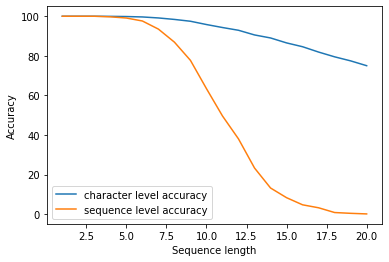

In [ ]:
plt.plot(np.arange(1,21), char, label="character level accuracy")
plt.plot(np.arange(1,21), seq, label="sequence level accuracy")
plt.gca().set_xlabel("Sequence length")
plt.gca().set_ylabel("Accuracy")
plt.legend(loc="lower left")

## RNN + Attention

We can augment our RNN with the ability to look back at any arbitrary point of the input sequence while decoding. To select what to look at, we use a so-called "attention mechanism"

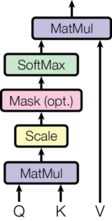

In [ ]:
class RNNEncoderDecoderAttn(torch.nn.Module):
  def __init__(self, d_model=32, vocab_size=30):
    super(RNNEncoderDecoderAttn, self).__init__()
    self.embeddings = torch.nn.Embedding(vocab_size, d_model)
    self.encoder = torch.nn.GRU(input_size=d_model, hidden_size=d_model, batch_first=True)
    self.decoder = torch.nn.GRUCell(input_size=d_model, hidden_size=d_model)

    self.key_linear = torch.nn.Linear(d_model, d_model)
    self.query_linear = torch.nn.Linear(2*d_model, d_model)
    self.value_linear = torch.nn.Linear(d_model, d_model)
    self.output_linear = torch.nn.Linear(2*d_model, d_model)
    
    self.head = torch.nn.Linear(d_model, vocab_size)
    self.d_model = 32

  def encode(self, input, lengths):
    """
    input : long tensor of dim [batch_size, seq_len] 
    lengths: long tensor of dim [batch_size] containing the length of each sequence of the batch
    """
    batch_size = input.shape[0]
    assert lengths.shape[0] == batch_size

    ignore = input == -100
    input = input.masked_fill(ignore, 0)
    embedded = self.embeddings(input)
    packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
    return self.encoder(packed)

  def decode(self, encoding, target, target_lengths):
    encoder_outputs, encoder_hidden = encoding
    # we "unpack" the encoder outputs
    encoder_outputs, _ = pad_packed_sequence(encoder_outputs, batch_first=True)

    #NEW! The attention mechanism.
    key = self.key_linear(encoder_outputs)  # batch_size x in_seq_len x d_model 
    value = self.value_linear(encoder_outputs)

    bs = target.shape[0]
    # Append start of sequence (SOS)
    target = torch.cat((torch.full((bs, 1,), SOS, device=target.device, dtype=target.dtype), target), dim=1)

    ignore = target == -100
    target = target.masked_fill(ignore, 0)
    embedded = self.embeddings(target)

    target_lengths = target_lengths + 1# adding 1 because of SOS
    max_len = torch.max(target_lengths).item() 
    assert max_len <= target.shape[1]
    decoded = []
    hidden = encoder_hidden.clone().squeeze(0)
    for i in range(max_len):
      current_active = i < target_lengths # binary mask, telling us which sequences are being forwarded

      cur_embed = embedded[:, i]
      query = self.query_linear(torch.cat([cur_embed, hidden], dim=-1)).unsqueeze(1) # batch_size x 1 x d_model
      attn = torch.matmul(query, key.transpose(-1,-2)) # batch_size x 1 x in_seq_len
      attn = attn.softmax(-1)

      cur_embed = self.output_linear(torch.cat([cur_embed, torch.matmul(attn, value).squeeze(1)], dim=-1))
      hidden[current_active] = self.decoder(cur_embed[current_active], hidden[current_active])
      decoded.append(hidden.clone())
    
    decoded = torch.stack(decoded, dim=1)
    return self.head(decoded)[:, :-1]


  def forward(self, input, input_lengths, target, target_lengths):
    return self.decode(self.encode(input, input_lengths), target, target_lengths)

  def inference(self, input, input_lengths, max_len=100):
    # track which sequences are done
    batch_size = input.shape[0]
    device = input.device
    done = torch.zeros(batch_size, dtype=torch.bool, device=device)

    # Encode the input sequence
    encoder_outputs, hidden = self.encode(input, input_lengths)
    hidden = hidden.squeeze(0)
    # we "unpack" the encoder outputs
    encoder_outputs, _ = pad_packed_sequence(encoder_outputs, batch_first=True)
    key = self.key_linear(encoder_outputs)  # batch_size x in_seq_len x d_model 
    value = self.value_linear(encoder_outputs)
    
    decoded_seq = [[] for _ in range(batch_size)]
    decoded_vec = self.embeddings(torch.full((batch_size,), SOS,  device=device, dtype=input.dtype)) # Start of sequence

    query = self.query_linear(torch.cat([decoded_vec, hidden], dim=-1)).unsqueeze(1) # batch_size x 1 x d_model

    attn = torch.matmul(query, key.transpose(-1,-2)) # batch_size x out_seq_len x in_seq_len
    attn = attn.softmax(-1)

    decoded_vec = self.output_linear(torch.cat([decoded_vec, torch.matmul(attn, value).squeeze(1)], dim=-1))

    # greedy decoding
    for i in range(max_len):
      if done.all().item():
        break

      hidden = self.decoder(decoded_vec, hidden)

      # Decode the prediction
      prediction = self.head(hidden).view(batch_size, -1).argmax(-1)

      # Re-encode for the next step
      decoded_vec = self.embeddings(prediction)

      query = self.query_linear(torch.cat([decoded_vec, hidden], dim=-1)).unsqueeze(1) # batch_size x 1 x d_model

      attn = torch.matmul(query, key.transpose(-1,-2)) # batch_size x out_seq_len x in_seq_len
      attn = attn.softmax(-1)

      decoded_vec = self.output_linear(torch.cat([decoded_vec, torch.matmul(attn, value).squeeze(1)], dim=-1))

      # Check which sequences have finished at this step
      done = done | (prediction == EOS)

      for j in range(batch_size):
        if done[j]:
          continue
        decoded_seq[j].append(prediction[j].item())

    return decoded_seq

In [ ]:
dataset = CopyDataset(max_length=20)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate_with_lengths)
model = RNNEncoderDecoderAttn(d_model=128).cuda()
optim = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

for i,(src, src_len, tgt, tgt_len) in enumerate(dataloader):
  src = src.cuda()
  tgt = tgt.cuda()
  optim.zero_grad()
  prediction = model(src, src_len, tgt, tgt_len)
  loss = torch.nn.functional.cross_entropy(prediction.flatten(0,1), tgt.flatten())


  loss.backward()
  optim.step()
  if i % 100 == 0:
    char_acc, seq_acc = validate(model, dataset, 1000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Char level accuracy=4.12	 Seq level accuracy=0.0	 loss=3.400177001953125
Char level accuracy=12.27	 Seq level accuracy=0.0	 loss=2.890352964401245
Char level accuracy=35.05	 Seq level accuracy=2.8	 loss=2.2525198459625244
Char level accuracy=97.18	 Seq level accuracy=74.2	 loss=0.12447424978017807
Char level accuracy=99.33	 Seq level accuracy=92.7	 loss=0.03939985856413841
Char level accuracy=99.43	 Seq level accuracy=94.1	 loss=0.03496863320469856
Char level accuracy=99.63	 Seq level accuracy=96.0	 loss=0.02741291932761669
Char level accuracy=99.76	 Seq level accuracy=97.3	 loss=0.01482226513326168
Char level accuracy=99.7	 Seq level accuracy=96.5	 loss=0.015856217592954636
Char level accuracy=99.78	 Seq level accuracy=97.5	 loss=0.007853996939957142
Char level accuracy=99.79	 Seq level accuracy=97.6	 loss=0.015050804242491722
Char level accuracy=99.78	 Seq level accuracy=97.4	 loss=0.009956778958439827
Char level accuracy=99.73	 Seq level accuracy=97.3	 loss=0.010212377645075321
Char

KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

char_attn, seq_attn = [], []
for i in tqdm(range(1, 21)):
  dataset = CopyDataset(min_length=i, max_length=i)
  char_acc, seq_acc = validate(model, dataset, 1000)
  char_attn.append(char_acc)
  seq_attn.append(seq_acc)

100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


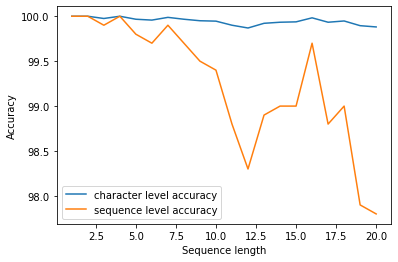

In [ ]:
plt.plot(np.arange(1,21), char_attn, label="character level accuracy")
plt.plot(np.arange(1,21), seq_attn, label="sequence level accuracy")
plt.gca().set_xlabel("Sequence length")
plt.gca().set_ylabel("Accuracy")
plt.legend(loc="lower left")


We can compare to the version without attention

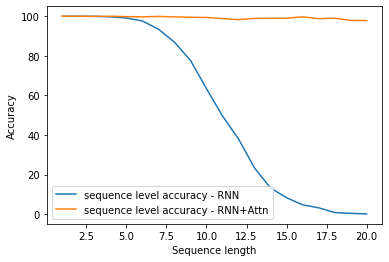

In [ ]:
plt.plot(np.arange(1,21), seq, label="sequence level accuracy - RNN")
plt.plot(np.arange(1,21), seq_attn, label="sequence level accuracy - RNN+Attn")
plt.gca().set_xlabel("Sequence length")
plt.gca().set_ylabel("Accuracy")
plt.legend(loc="lower left")

## Transformers

We have seen the huge boot provided by the attention mechanism. It begs the question, can we rely solely on that, and ditch the recurrent part? The modern architecture called Transformer does exactly that.

### Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. **At each step the model is auto-regressive [(cite)](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next.** 

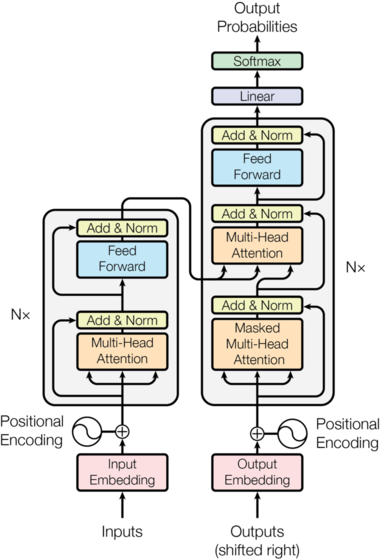

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


#### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
# To create N copies of a layer
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection [(cite)](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization [(cite)](https://arxiv.org/abs/1607.06450).  

In [ ]:
Image(filename='images/EncoderSublayers.png')

NameError: ignored

TODO 2min explanation on Layernorm

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn  # will explain later
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

#### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.  

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts **a third sub-layer, which performs multi-head attention over the output of the encoder stack**.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

In [ ]:
Image(filename='images/Decoder.png')

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify **the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions**.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

> Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

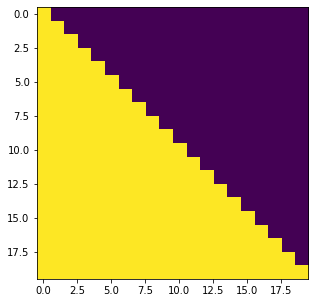

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

#### Attention                                                                                                                                                                                                                                                                             
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a **weighted sum of the values**, where the weight assigned to each value is computed by a **compatibility function of the query with the corresponding key**.                                                                                                                                                                                                                                                                                   

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                                                                                                                                                  
                                                                                                                                                                     

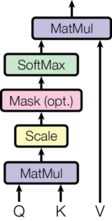


In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention [(cite)](https://arxiv.org/abs/1409.0473), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

                                                                        
While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](https://arxiv.org/abs/1703.03906). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

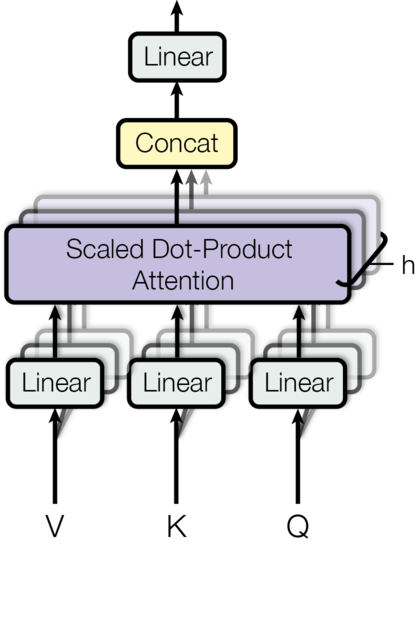

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                            
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                             In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality. 

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

Applications of Attention in our Model                                                                                                                                                      
The Transformer uses multi-head attention in three different ways:                                                        
1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [(cite)](https://arxiv.org/abs/1609.08144).    


2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   


3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                                                                                                                                                      

#### Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

#### Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                                                                                                                                 

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

#### Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to **make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence**.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized **it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$**. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [ ]:
Image(filename='images/positional_emb.png')

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

> Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension. 

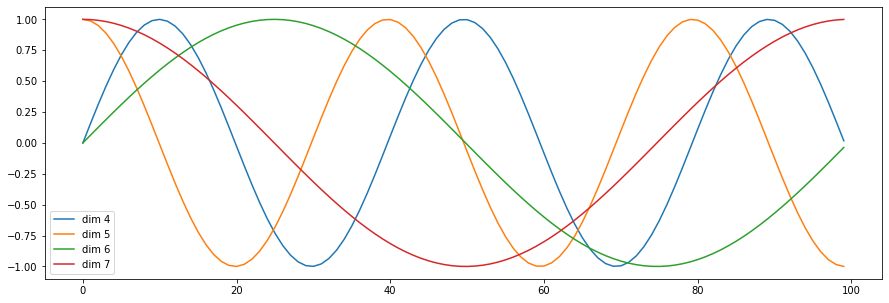

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings [(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

### Inference

Finally, we describe how we do autoregressive (greedy) decoding with a transformer.

In [ ]:
@torch.no_grad()
def transformer_inference(model, src, src_mask, max_len=100):
  batch_size = src.shape[0]

  # encode the input sequence
  encoded = model.encode(src, src_mask)
  tgt = torch.full((batch_size, 1), SOS, device=src.device)

  decoded_seq = [[] for _ in range(batch_size)] 
  # This binary vector tells us which sequences are fully decoded
  done = torch.zeros(batch_size, dtype=torch.bool, device=src.device)

  for i in range(max_len):
    if done.all().item():
      # exit early if everything is decoded.
      break

    # prepare decoding side mask
    tgt_mask = subsequent_mask(tgt.size(-1)).type_as(src_mask.data)

    # decode one step, take the last output
    decoded = model.decode(encoded, src_mask, tgt, tgt_mask)[:, -1]

    # We do greedy decoding, ie take the most likely token
    prediction = decoded.argmax(-1)

    # Append the prediction to the decoding
    tgt = torch.cat([tgt, prediction.unsqueeze(1)], 1)

    # Check which sequences have finished at this step
    done = done | (prediction == EOS)

    for j in range(batch_size):
      if done[j]:
        continue
      decoded_seq[j].append(prediction[j].item())

  return decoded_seq



### Full Model

> Here we define a function from hyperparameters to a full model. 

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [ ]:
@torch.no_grad()
def validate(model, dataset, num=1000):
  # Don't forget to put the model in eval!
  model.eval()

  # Get examples from the dataset
  examples = [dataset[i] for i in range(num)]
  # Collate them
  src, tgt = padded_collate(examples)
  # send them to GPU
  src = src.cuda()
  tgt = tgt.cuda()
  orig_tgt = tgt.clone()  # Keep a copy of the target

  # The source mask consists of all the tokens that are NOT padding
  src_mask = (src != -100).unsqueeze(-2)
  # Fill with 0s to avoid issues with the embeddings.
  src.masked_fill_(~src_mask.squeeze(-2), 0)

  # prepend SOS
  tgt = torch.cat([torch.full((tgt.shape[0], 1), SOS, dtype=tgt.dtype, device=tgt.device), tgt], dim=1)
  tgt_mask = (tgt != -100).unsqueeze(-2)
  tgt.masked_fill_(~tgt_mask.squeeze(-2), 0)
  # create triangular mask for decoding
  tgt_mask = tgt_mask & (
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
  # Run forward, take argmax (most likely token at each step)
  prediction = model(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask).argmax(-1)[:, :-1]

  # Compute character level accuracy
  valid = orig_tgt != -100
  acc = prediction[valid] == orig_tgt[valid]
  acc = (acc.sum()) / (valid.sum())
  char_acc = acc.item()*100

  # Compute sequence level accuracy, by actually doing the inference
  inferred = transformer_inference(model, src, src_mask)
  valid = 0
  for i in range(num):
    if inferred[i] == examples[i][1].tolist()[:-1]:
     valid += 1

  return char_acc, 100*valid/num

In [ ]:
dataset = CopyDataset(max_length=20, vocab_size=20)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate)
model = make_model(22,22, N=2, d_model=64, d_ff=128, h=4).cuda()

# Note that we now switch to Adam as the optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for i,(src,tgt) in enumerate(dataloader):
  model.train()
  # Send data to GPU
  src = src.cuda()
  tgt = tgt.cuda()
  orig_tgt = tgt.clone()  # keep a copy of the target for loss computation
  # prepend SOS
  tgt = torch.cat([torch.full((tgt.shape[0], 1), SOS, dtype=tgt.dtype, device=tgt.device), tgt], dim=1)

  optim.zero_grad()
  src_mask = (src != -100).unsqueeze(-2)
  src.masked_fill_(~src_mask.squeeze(-2), 0)

  tgt_mask = (tgt != -100).unsqueeze(-2)
  tgt.masked_fill_(~tgt_mask.squeeze(-2), 0)
  tgt_mask = tgt_mask & (
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
  

  prediction = model(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)[:, :-1]


  # Loss is still a standard cross entropy
  loss = torch.nn.functional.cross_entropy(prediction.flatten(0,1), orig_tgt.flatten())


  loss.backward()
  optim.step()
  if i % 100 == 0 and i > 0:
    char_acc, seq_acc = validate(model, dataset, 1000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Char level accuracy=88.75	 Seq level accuracy=50.1	 loss=0.8268156051635742
Char level accuracy=99.77	 Seq level accuracy=97.6	 loss=0.1223289966583252
Char level accuracy=99.96	 Seq level accuracy=99.5	 loss=0.06056162342429161
Char level accuracy=99.89	 Seq level accuracy=98.8	 loss=0.03597036004066467
Char level accuracy=100.0	 Seq level accuracy=100.0	 loss=0.03490576893091202


KeyboardInterrupt: ignored

Let's do one inference to check if everything works as expected

In [ ]:
src = torch.as_tensor([5,6,7,8,EOS], dtype=torch.long).unsqueeze(0).cuda()
src_mask = torch.ones(src.shape, dtype=torch.bool, device=src.device)
transformer_inference(model, src, src_mask)

[[5, 6, 7, 8]]

## So, are RNN dead? Not so fast!

On the copy task, we've seen that a vanilla RNN struggles because it has to remember an arbitrarily long sequence in a finite vector. The transformer, on the other hand, can freely go back and look at whatever part of the sentence it pleases. But what if the task doesn't require looking back, but instead involves maintaining a local state while processing the sequence?

A natural example of that is performing the sum of a given sequence: at each time-step, you only need the sum so far and the value of the current number, but you never need to look back to the rest of sequence. Another example is following directions in a maze: to know where the agent will be next, you only need to know where it currently is and what direction it is walking towards, but you don't need to know the full history.

As a simple example, we will study parity: given a sequence of 3s and 4s, the network must predict whether the sum of all the number is even or odd.

In [ ]:
# Our class inherits from pytorch's dataset class
class ParityDataset(torch.utils.data.Dataset):
  def __init__(self, min_length=1, max_length=20):
    super().__init__()
    self.min_length = min_length
    self.max_length = max_length

  def __len__(self):
    return 1000000 # Arbitrary dataset length

  def __getitem__(self, idx):
    # Here we generate a random sample.
    length = randint(self.min_length, self.max_length)
    input = torch.randint(2, 4, (length + 1,))
    parity = input[:-1].sum() % 2
    input[-1] = EOS # The last token is a special class called "End of Sequence" or EOS
    return input, parity.unsqueeze(0)

Let's start with the transformer. We use the same architecture as before, and use a BCE loss to train

In [ ]:
from itertools import chain

dataset = ParityDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate)
dataloader_val = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate)
model = make_model(12,12, N=2, d_model=64, d_ff=128, h=4).cuda()
head = torch.nn.Linear(64,1).cuda()
optim = torch.optim.Adam(chain(model.parameters(), head.parameters()), lr=0.01)

for i,(src,tgt) in enumerate(dataloader):
  model.train()
  src = src.cuda()
  tgt = tgt.squeeze().cuda().float()
  # prepend CLS
  src = torch.cat([torch.full((src.shape[0], 1), SOS, dtype=src.dtype, device=src.device), src], dim=1)

  optim.zero_grad()
  src_mask = (src != -100).unsqueeze(-2)
  src.masked_fill_(~src_mask.squeeze(-2), 0)

  prediction = head(model.encode(src, src_mask)[:, 0]).squeeze()
  
  # This is a binary prediction, henc we use binary cross entropy
  loss = torch.nn.functional.binary_cross_entropy_with_logits(prediction, tgt)


  loss.backward()
  optim.step()
  if i % 100 == 0:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for src_val, tgt_val in dataloader_val:
        src_val = src_val.cuda()
        tgt_val = tgt_val.squeeze().cuda()
        src_val = torch.cat([torch.full((src_val.shape[0], 1), SOS, dtype=src_val.dtype, device=src_val.device), src_val], dim=1)
        src_mask_val = (src_val != -100).unsqueeze(-2)
        src_val.masked_fill_(~src_mask_val.squeeze(-2), 0)
        prediction = head(model.encode(src_val, src_mask_val)[:, 0]).squeeze().sigmoid() > 0.5
        correct += (prediction.long() == tgt_val.long()).sum().item()
        total += prediction.numel()
        if total >= 1000:
          break
    print(f"Accuracy={round(100*correct / total, 2)}\t loss={loss.item()}")
        
    continue
    char_acc, seq_acc = validate(model, dataset, 1000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Accuracy=49.71	 loss=0.7704175710678101
Accuracy=55.96	 loss=0.6922661662101746
Accuracy=56.15	 loss=0.6701476573944092
Accuracy=54.69	 loss=0.65822434425354


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ea991f80>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ea991f80>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionE

Accuracy=56.74	 loss=0.6751006841659546
Accuracy=54.3	 loss=0.6295434832572937
Accuracy=58.98	 loss=0.6447842717170715
Accuracy=54.59	 loss=0.6472184658050537
Accuracy=55.47	 loss=0.6541621088981628
Accuracy=52.54	 loss=0.634220540523529
Accuracy=57.32	 loss=0.6477200388908386
Accuracy=54.39	 loss=0.6212984323501587
Accuracy=54.79	 loss=0.6269477605819702
Accuracy=59.28	 loss=0.6400529742240906
Accuracy=58.98	 loss=0.6461488008499146
Accuracy=58.11	 loss=0.6213938593864441
Accuracy=59.38	 loss=0.6171269416809082
Accuracy=60.16	 loss=0.6154794692993164
Accuracy=58.69	 loss=0.6198768615722656
Accuracy=58.3	 loss=0.621833086013794
Accuracy=59.47	 loss=0.6042935848236084
Accuracy=61.04	 loss=0.6075913906097412
Accuracy=57.91	 loss=0.5991491675376892
Accuracy=60.45	 loss=0.578950047492981
Accuracy=58.01	 loss=0.6185245513916016
Accuracy=57.03	 loss=0.6195989847183228
Accuracy=59.47	 loss=0.619225025177002


KeyboardInterrupt: ignored

As you can see, the loss doesn't go down. The transformer is not able to meaningfully beat chance at this task

In [ ]:
from itertools import chain

dataset = ParityDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=2, collate_fn=padded_collate_with_lengths)
dataloader_val = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=0, collate_fn=padded_collate_with_lengths)
model = RNNEncoderDecoder(d_model=64, vocab_size=10).cuda()
head = torch.nn.Linear(64,1).cuda()
optim = torch.optim.SGD(chain(model.parameters(), head.parameters()), lr=0.1, momentum=0.9)

for i,(src, src_len, tgt, tgt_len) in enumerate(dataloader):
  model.train()
  optim.zero_grad()

  src = src.cuda()
  tgt = tgt.squeeze().cuda().float()

  prediction = head(model.encode(src, src_len)).squeeze()
  
  loss = torch.nn.functional.binary_cross_entropy_with_logits(prediction, tgt)


  loss.backward()
  optim.step()
  if i % 100 == 0:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for i,(src_val, src_len_val, tgt_val, tgt_len_val) in enumerate(dataloader):
        src_val = src_val.cuda()
        tgt_val = tgt_val.squeeze().cuda()

        prediction = head(model.encode(src_val, src_len_val)).squeeze().sigmoid() > 0.5
        correct += (prediction.long() == tgt_val.long()).sum().item()
        total += prediction.numel()
        if total >= 1000:
          break
    print(f"Accuracy={round(100*correct / total, 2)}\t loss={loss.item()}")
        
    continue
    char_acc, seq_acc = validate(model, dataset, 1000)
    print(f"Char level accuracy={round(char_acc, 2)}\t Seq level accuracy={seq_acc}\t loss={loss.item()}")

Accuracy=47.36	 loss=0.6966860890388489
Accuracy=56.64	 loss=0.6632989048957825
Accuracy=100.0	 loss=0.0037074314896017313


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ea991f80>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ea991f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionE

Accuracy=100.0	 loss=0.0011222754837945104
Accuracy=100.0	 loss=0.0006060941959731281
Accuracy=100.0	 loss=0.00036329508293420076
Accuracy=100.0	 loss=0.0003247952845413238
Accuracy=100.0	 loss=0.0002684917417354882
Accuracy=100.0	 loss=0.00017957121599465609
Accuracy=100.0	 loss=0.00015527955838479102
Accuracy=100.0	 loss=0.000128977102576755
Accuracy=100.0	 loss=0.0001605189172551036
Accuracy=100.0	 loss=9.355494694318622e-05
Accuracy=100.0	 loss=8.314929436892271e-05


KeyboardInterrupt: ignored

This task is very easy for a simple RNN! The accuracy shoots to 100% immediately. As often in deep-learning, there is no silver bullet, one must choose the tool best suited for the task at hand.

As a bonus, let's see if the RNN actually generalizes. Let's test it on sequences 10x longer than seen during training:

In [ ]:

dataset_val = ParityDataset(min_length=200, max_length=200)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=256, num_workers=0, collate_fn=padded_collate_with_lengths)
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for i,(src_val, src_len_val, tgt_val, tgt_len_val) in enumerate(dataloader):
    src_val = src_val.cuda()
    tgt_val = tgt_val.squeeze().cuda()

    prediction = head(model.encode(src_val, src_len_val)).squeeze().sigmoid() > 0.5
    correct += (prediction.long() == tgt_val.long()).sum().item()
    total += prediction.numel()
    if total >= 1000:
      break
print(f"Accuracy={round(100*correct / total, 2)}")

Accuracy=100.0


The accuracy remains at 100%, hence the function learnt by the model is presumably the "correct" one. Note, however, that training the RNN directly on sequences of size 200 would be challenging (try it!), due to vanishing gradients.
The approach we used here, that is training on short sequences first then testing on long ones is called **curriculum learning**. It is commonly used in practice to overcome trainging difficulties.